In [1]:
from deployment_utils import generateSessions, generateExpectedDemand, generateBackupPrices, table_to_stateRecord, unixTime
import pandas as pd 
import time
import pandas as pd
import numpy as np
import datetime
import copy
from collections import defaultdict
import json
import os
import random
from decimal import Decimal
from matplotlib.dates import DateFormatter
# #### AWS FUNCTIONS ####
from fastapi import FastAPI, Response, status, Body, Request
from fastapi.encoders import jsonable_encoder
from fastapi.middleware.cors import CORSMiddleware
from fastapi.staticfiles import StaticFiles
from fastapi.templating import Jinja2Templates


import boto3, json, hashlib, time, random, pickle
from boto3.dynamodb.conditions import Key, Attr

app = FastAPI()
# Obtain secret key for AWS
txt_path = '/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-digital-twin/src/'
f = open(txt_path +"secret.txt")
text = f.readlines()

# Access dynamodb on AWS
dynamodb = boto3.resource(
    "dynamodb",
    aws_access_key_id=text[0][:-1],
    aws_secret_access_key=text[1][:-1],
    region_name="us-east-2")

DAY_SECONDS = 86400
FOUR_HR_SECONDS = 4*3600
NO_SITES = 1
WS_TO_KWH = 1/(1000*3600)
WH_TO_KWH = 1/1000

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

CVXPY version: 1.1.7


ModuleNotFoundError: No module named 'fastapi'

In [ ]:
## PLOT SETTINGS
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

plt.style.use(['science','ieee','high-vis'])
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] =300
plt.rcParams['font.size'] = 14
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
matplotlib.rc('axes', labelsize=14)

w = 7/1.1
h = 3/1.1

color_palette = [
    '#1655db',  # Slightly darker version of '#0d49fb'
    '#d70210',  # Slightly darker version of '#e6091c'
    '#2df957',  # Lighter shade of '#26eb47'
    '#7d2ecd',  # Desaturated shade of '#8936df'
    '#edc429',  # Slightly desaturated version of '#fec32d'
    '#2ac8ed',  # Desaturated version of '#25d7fd'
    '#e5692f',  # Slightly different shade of '#f07933'
    '#12bf51',  # Slightly darker version of '#14d45e'
    '#a110a4',  # Slightly darker version of '#b812b3'
    # '#edbf0a',  # Slightly darker shade of '#f9cb0b' - colorblind safety
    '#19c7d6'   # Slightly darker version of '#1ad3ea'
]

sns.palplot(color_palette)
plt.show()

In [ ]:
def extract_session_powers(session_lst, interval=5):
    session_lst = json.loads(session_lst)
    sessions_powers = []
    sessions_timestamp = []
    for ts_power in session_lst:
        sessions_powers.append(float(ts_power["M"]['power_W']["N"]))
        sessions_timestamp.append(float(ts_power["M"]['timestamp']["N"]))
    session_pow = pd.DataFrame(index =pd.to_datetime(pd.Series(sessions_timestamp),unit='s').dt.floor('{}min'.format(interval)) , 
                                data = {"power_w":sessions_powers})
    session_pow = session_pow.tz_localize("utc").tz_convert("US/Pacific")
    session_pow['power_w'] = session_pow['power_w'].astype(float)
    return session_pow


def extract_session_data(df,row, interval = 5):

    """ Input: DataFrame of historical sessions 
        Everything in 5 min intervals 
    """
    
    start_interval =df.loc[row,"connectTime"].floor('5min') 
    end_interval =df.loc[row,"lastUpdate"].floor('5min') 
    duration_periods = int(df.loc[row,"DurationHrs"] * 60 / interval)
    # Create a dataframe with index from connectTime to disconnectTime time. Round down to nearest 15 minutes? 

    if start_interval < phase3_start:
        session_pow =  extract_session_powers(df.loc[row,"power"])
        assert (session_pow["power_w"].sum() * (interval/60)) / 1000 > 0, "Baseline Power Timestamp Mismatch"
        index = pd.date_range(start= start_interval , end =  end_interval,freq="{}min".format(interval) ,tz="US/Pacific")
    else: 
        start_interval =df.loc[row,"connectTime"].floor('1H') 

        session_pow, est_duration_hours =  extract_optimized_powers(df , powers, row , interval = 15)
        
        session_pow = session_pow.resample('{}min'.format(interval)).ffill()
        duration_periods = int(est_duration_hours * 60 / interval)
        index = pd.date_range(start= start_interval , periods =  duration_periods, freq="{}min".format(interval) ,tz="US/Pacific")
        session_pow_irl =  extract_session_powers(df.loc[row,"power"])
        

         

    

    session_df = pd.DataFrame(index=index, columns = ["userId",  'reg_centsPerHr', 'sch_centsPerHr', 'sch_centsPerOverstayHr', "vehicle_maxChgRate_W","" ,"connectionStatus", "chargingStatus","overstayStatus","power_w"])


    
    assert session_pow.index[0] >= session_df.index[0], "Charging strats before connection {} >= {}".format(session_pow.index,session_df.index )

    # power_w column must be null when not charging 
    session_df["power_w"] =session_pow
    session_df["userId"] = df.loc[row,"userId"]
    session_df["dcosId"] = df.loc[row,"dcosId"]
    session_df["choice"] = df.loc[row,"choice"] 
    session_df["reg_centsPerHr"] = df.loc[row,"reg_centsPerHr"] 
    session_df["sch_centsPerHr"] = df.loc[row,"sch_centsPerHr"] 
    session_df["sch_centsPerOverstayHr"] = df.loc[row,"sch_centsPerOverstayHr"] 
    session_df["vehicle_maxChgRate_W"] = df.loc[row,"vehicle_maxChgRate_W"] 
    session_df["connectionStatus"] = 1
    session_df["chargingStatus"] = (~session_df["power_w"].isnull()).astype(int)
    session_df["overstayStatus"] = 0
    session_df["TOU (cents/kwh)"] = sessions_TOU(start_interval.date())["TOU (cents/kwh)"]
    session_df["DurationHrs"] = df.loc[row,"DurationHrs"]
    if start_interval < phase3_start:
        session_df['connectedDuration_Hrs'] = (df.loc[row,'lastUpdate'] - df.loc[row,'connectTime']).seconds / 3600 
    else: 
        session_df['connectedDuration_Hrs'] = est_duration_hours
    
    try:
        session_df['Energy_IRL'] =(float(session_pow_irl.sum()) * (interval/60)) / 1000
    except: 
        session_df['Energy_IRL'] =(float(session_pow.sum()) * (interval/60)) / 1000
    return session_df
####### CHOICE: WHICH TIMEFRAME TO USE FOR THE EXPECTED DEMAND TABLE ##### 
session_df = generateSessions(2023, 10, 16, 0,
                                    2024, 2, 6, 19,
                                    write_output = False,
                                    all_data = False,
                                    path = "/Users/aysetugbaozturk/Documents/eCal/SlrpEV/SlrpEV_algorithms/",
                                    f_name = "",
                                    read_from_file=False)

Length of Scanned Items is 899 items
Length of Scanned Items is 1780 items
Length of Scanned Items is 2708 items
Length of Scanned Items is 3598 items
Length of Scanned Items is 4533 items
Length of Scanned Items is 5213 items
Elapsed time: 0 minutes, 7 seconds
From 2023-10-16 00:00:00 till 2024-01-30 19:00:00 (incl.)


In [ ]:
# ####### CHOICE: WHICH TIMEFRAME TO USE FOR THE EXPECTED DEMAND TABLE ##### 
# leave_experiment = generateSessions(2023, 8,17, 0,
#                                     2023, 9, 16, 0,
#                                     write_output = False,
#                                     all_data = False,
#                                     path = "/Users/aysetugbaozturk/Documents/eCal/SlrpEV/SlrpEV_algorithms/",
#                                     f_name = "",
#                                     read_from_file=False)

In [ ]:
######## General Statistics of the Experiment ####### 
print("Total sessions:", len(session_df))
print("REG sessions:", session_df.groupby(['choice']).count().loc['REGULAR','dcosId'])
print("SCH sessions:", session_df.groupby(['choice']).count().loc['SCHEDULED','dcosId'])

session_df[['connectTime','userId','dcosId','choice','reg_centsPerHr','sch_centsPerHr','connectTime']].tail(20)
session_df

Total sessions: 613
REG sessions: 457
SCH sessions: 156


choice vehicle_maxChgRate_W siteId peakPower_W   estCost  \
4908    REGULAR                 6600     25           0  11.14878   
5098    REGULAR                11000     25        6813   9.54284   
1818  SCHEDULED                55000     25           0   12.4196   
3834    REGULAR                 6600     25        6493   12.1219   
5099    REGULAR                11000     25        6821   0.92844   
...         ...                  ...    ...         ...       ...   
3592  SCHEDULED                 7700     25        6705  12.84453   
5164    REGULAR               250000     25        6437    7.0975   
4332    REGULAR                11500     25        6748   6.51666   
5029    REGULAR                11000     25        3428   3.76463   
931     REGULAR                 6600     25        6705   1.97911   

     sch_centsPerHr         connectTime  DurationHrs  \
4908            166 2023-10-16 07:48:56      5.43305   
5098            168 2023-10-16 08:04:26      4.59027   
1818            168 2023-10-16 09:23:50      6.92972   
3834            168 2023-10-16 11:39:23      5.89944   
5099            169 2023-10-16 12:51:40      0.21638   
...             ...                 ...          ...   
3592            163 2024-01-30 09:24:57      1.24138   
5164            200 2024-01-30 09:36:03      4.39833   
4332            200 2024-01-30 09:58:04      4.01111   
5029             99 2024-01-30 11:03:09      2.94111   
931             175 2024-01-30 13:17:17      0.71111   

                  vehicle_model dcosId  ... sch_centsPerKwh  \
4908  Leaf  (30 kW-hr upgraded)   6099  ...               0   
5098                    Model Y   6102  ...               0   
1818               Clarity PHEV   6103  ...               0   
3834                       Leaf   6104  ...               0   
5099                    Model Y   6105  ...               0   
...                         ...    ...  ...             ...   
3592                    Model 3   6908  ...               0   
5164    Model 3 AWD Longe Range   6910  ...               0   
4332                    Model Y   6911  ...               0   
5029                       Volt   6912  ...               0   
931                Clarity PHEV   6913  ...               0   

     sch_centsPerOverstayHr            Deadline energyReq_Wh arrHour  \
4908                    300                 NaT          NaN       7   
5098                    300                 NaT          NaN       8   
1818                    300 2023-10-16 16:30:00        17000       9   
3834                    300                 NaT          NaN      11   
5099                    300                 NaT          NaN      12   
...                     ...                 ...          ...     ...   
3592                    300 2024-01-30 17:00:00        24785       9   
5164                    300                 NaT          NaN       9   
4332                    300                 NaT          NaN       9   
5029                    300                 NaT          NaN      11   
931                     300                 NaT          NaN      13   

     cumEnergy_KWh historical_peakPower_w             endTime highPower  \
4908        24.199                   6522 2023-10-16 13:15:05       1.0   
5098        29.620                   6859 2023-10-16 12:40:05       1.0   
1818        11.857                   6738 2023-10-16 16:20:05       1.0   
3834        36.372                   6611 2023-10-16 17:35:05       1.0   
5099         1.240                   6859 2023-10-16 13:05:05       1.0   
...            ...                    ...                 ...       ...   
3592         7.719                   6830 2024-01-30 10:40:05       1.0   
5164        26.527                   6908 2024-01-30 14:00:06       1.0   
4332        25.252                   6869 2024-01-30 14:00:06       1.0   
5029         9.525                   3449 2024-01-30 14:00:06       0.0   
931          4.320                   6705 2024-01-30 14:00:0

In [ ]:
print(len(session_df[session_df["connectTime"] > pd.Timestamp(year=2023,month=11,day=21,hour=0)]))
session_df[session_df["connectTime"] > pd.Timestamp(year=2023,month=11,day=21,hour=0)]['choice'].value_counts()
91/275

366


0.33090909090909093

In [ ]:
table = dynamodb.Table('stateRecords_History')

# Scan the table
response = table.scan()
response['Items']

[{'sort_key': Decimal('0'),
  'sessions': [{'optPower': [[Decimal('1705050000'), Decimal('6600')],
     [Decimal('1705050900'), Decimal('124')],
     [Decimal('1705051800'), Decimal('6600')],
     [Decimal('1705052700'), Decimal('6600')],
     [Decimal('1705053600'), Decimal('5')],
     [Decimal('1705054500'), Decimal('6600')],
     [Decimal('1705055400'), Decimal('6600')],
     [Decimal('1705056300'), Decimal('6600')],
     [Decimal('1705057200'), Decimal('0')],
     [Decimal('1705058100'), Decimal('6600')],
     [Decimal('1705059000'), Decimal('6600')],
     [Decimal('1705059900'), Decimal('6600')],
     [Decimal('1705060800'), Decimal('6600')],
     [Decimal('1705061700'), Decimal('6600')],
     [Decimal('1705062600'), Decimal('6600')],
     [Decimal('1705063500'), Decimal('6600')],
     [Decimal('1705064400'), Decimal('6600')],
     [Decimal('1705065300'), Decimal('6600')],
     [Decimal('1705066200'), Decimal('6600')],
     [Decimal('1705067100'), Decimal('6600')],
     [Decimal('

In [ ]:
def scan_stateRecord_History():
    # Dictionary to store the data
    stateRecords = []

    table = dynamodb.Table('stateRecords_History')

    # Scan the table
    response = table.scan()

    # Handle Decimal types coming from DynamoDB
    def decimal_default(obj):
        if isinstance(obj, Decimal):
            return float(obj)
        raise TypeError
    print(len(response['Items']))
    # Process scanned items
    for item in response['Items']:
        
        try: 
            timestamp = decimal_default(item['timestamp'])
        except KeyError:
            timestamp = decimal_default(item['timeStamp'])

        # Populate data
        stateRecord= {"timestamp":int(timestamp),
                      "sort_key":int(decimal_default(item['sort_key'])),
                    'monthlyPeak': decimal_default(item['monthlyPeak']),
                    'sessions': [
                {
                    'dcosId': int(session['dcosId']),
                    'choice': session['choice'],
                    'powerRate': session['powerRate'],
                    'energyNeeded': decimal_default(session['energyNeeded']),
                    'optPower': [[decimal_default(x) for x in pair] for pair in session['optPower']],
                    'deadline': int(session['deadline'])
                } for session in item['sessions']]
        }
        stateRecords.append(stateRecord)
    return stateRecords

# Handle Decimal types coming from DynamoDB
def decimal_default(obj):
    if isinstance(obj, Decimal):
        return float(obj)
    raise TypeError

In [ ]:
stateRecords = scan_stateRecord_History()
# Convert to DataFrame
df = pd.DataFrame(stateRecords, columns=['timestamp', 'sort_key','monthlyPeak', 'sessions'])
df = df.sort_values(by='timestamp').reset_index(drop=True)

df.rename(columns={'timestamp':'opt_timestamp'},inplace=True)
df['opt_timestamp'] = pd.to_datetime(df['opt_timestamp'],unit='s')
df_exp = df[df['opt_timestamp'] >= pd.Timestamp(year=2023, month=10, day= 16, hour=1)].reset_index(drop=True)
df_exp['opt_timestamp'] = pd.to_datetime(df_exp['opt_timestamp'],unit='s')
df_exp.sort_values(by= 'opt_timestamp',inplace=True)
# df_exp = df_exp.drop_duplicates(subset='opt_timestamp',keep='last')
# df_exp.reset_index(drop=True,inplace=True)

1439


In [32]:
# from matplotlib.dates import DateFormatter
# plt.rcParams['font.family'] = 'Times New Roman'
# fig, axes = plt.subplots(3,1,figsize=(w, h * 2),sharex=True)

# ax=axes[0]
# ax.set_title("State at:"+str(pd.Timestamp(year=2023,month=10,day=16,hour=7)))
# sessions = df_exp.loc[98,'sessions']
# for session in sessions:
#     temp = pd.DataFrame(session['optPower'],dtype='int')
#     temp[0]=pd.to_datetime(temp[0],unit='s')
#     temp.set_index(0,inplace=True)
#     ax.plot(temp,label="Id:{},choice:{}".format(session['dcosId'],session['choice']))
# ax.legend()

# ax=axes[1]
# ax.set_title("State at:"+str(df_exp.loc[99,'opt_timestamp']))
# sessions = df_exp.loc[99,'sessions']
# for session in sessions:
#     temp = pd.DataFrame(session['optPower'],dtype='int')
#     temp[0]=pd.to_datetime(temp[0],unit='s')
#     temp.set_index(0,inplace=True)
#     ax.plot(temp,label="Id:{},choice:{}".format(session['dcosId'],session['choice']))
# ax.legend()
# # df_exp.loc[98,'sessions'][0]['opt']

# ax=axes[2]
# ax.set_title("State at:"+str(df_exp.loc[100,'opt_timestamp']))
# sessions = df_exp.loc[100,'sessions']
# for session in sessions:
#     temp = pd.DataFrame(session['optPower'],dtype='int')
#     temp[0]=pd.to_datetime(temp[0],unit='s')
#     temp.set_index(0,inplace=True)
#     ax.plot(temp,label="Id:{},choice:{}".format(session['dcosId'],session['choice']))
# ax.legend()

# for ax in axes:
#     ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
#     ax.set_ylabel('Power (W)')



In [13]:
# sessions = df_exp.loc[98,'sessions']
# cum_sum = pd.DataFrame(index=pd.to_datetime([x[0] for x in sessions[0]['optPower']], unit='s'))

# for session in sessions:
#     temp = pd.DataFrame(session['optPower'], dtype='int')
#     temp[0] = pd.to_datetime(temp[0], unit='s')
#     temp.set_index(0, inplace=True)
    
#     # Add to cumulative sum
#     prev_sum = cum_sum['value'].copy()
#     cum_sum['value'] += temp[1].reindex(cum_sum.index, fill_value=0)
        
#     ax.fill_between(cum_sum.index, prev_sum, cum_sum['value'], label="Id:{},choice:{}".format(session['dcosId'], session['choice']))

In [14]:
# from matplotlib.dates import DateFormatter
# import pandas as pd
# import matplotlib.pyplot as plt

# plt.rcParams['font.family'] = 'Times New Roman'
# fig, axes = plt.subplots(3,1,figsize=(w, h * 2))

# def plot_filled_stacked(ax, sessions, title):
#     ax.set_title(title)
    
#     # Initialize cumulative sum
#     # cum_sum = pd.DataFrame(index=pd.to_datetime(sessions[0]['optPower'], unit='s')[:, 0])
#     cum_sum = pd.DataFrame(index=pd.to_datetime([x[0] for x in sessions[0]['optPower']], unit='s'))

#     cum_sum['value'] = 0
    
#     for session in sessions:
#         temp = pd.DataFrame(session['optPower'], dtype='int')
#         temp[0] = pd.to_datetime(temp[0], unit='s')
#         temp.set_index(0, inplace=True)
        
#         # Add to cumulative sum
#         prev_sum = cum_sum['value'].copy()
#         cum_sum['value'] += temp[1].reindex(cum_sum.index, fill_value=0)
            
#         ax.fill_between(cum_sum.index, prev_sum, cum_sum['value'], label="Id:{},choice:{}".format(session['dcosId'], session['choice']))
    
#     ax.legend()

# plot_filled_stacked(axes[0], df_exp.loc[98,'sessions'], "State at:"+str(df_exp.loc[98,'opt_timestamp']))
# plot_filled_stacked(axes[1], df_exp.loc[99,'sessions'], "State at:"+str(df_exp.loc[99,'opt_timestamp']))
# plot_filled_stacked(axes[2], df_exp.loc[100,'sessions'], "State at:"+str(df_exp.loc[100,'opt_timestamp']))

# # Determine uniform y-range
# all_values = []
# for i in [98, 99, 100]:
#     for session in df_exp.loc[i, 'sessions']:
#         all_values.extend([val[1] for val in session['optPower']])
# # ymax = max(all_values)

# for ax in axes:
#     ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
#     ax.set_ylim(0,20000)

# plt.tight_layout()
# plt.show()


In [ ]:
df_exp = df_exp.sort_values(by=['opt_timestamp','sort_key']).drop_duplicates(subset='opt_timestamp',keep='last')
df_exp.reset_index(drop=True,inplace=True)

In [ ]:
unixTime(pd.Timestamp(year=2023,month=12,day=11,hour=12))

1702296000

In [ ]:
unix_time_index = np.arange(start=1697429700, stop= unixTime(pd.Timestamp(year=2024,month=1,day=30,hour=18)), step = 15 * 60)
df_sessions = pd.DataFrame(index = unix_time_index)


for row in range(len(df_exp)):
    sessions = df_exp.loc[row,"sessions"]
    optTime = df_exp.loc[row,"opt_timestamp"]
    sk = df_exp.loc[row,"sort_key"]
    if len(sessions) > 0 :
        for session in sessions:
            dcosId = session['dcosId']
            
            power = session['optPower']
            temp = pd.DataFrame(session['optPower'],dtype='int').set_index(0)

            col_name = str(dcosId)+"_"+str(sk)+"_"+str(optTime)
            col_name = str(dcosId)
            df_sessions[col_name] = temp

df_sessions.reset_index(drop=False,inplace=True, names='timestamp')
df_sessions['timestamp'] = pd.to_datetime(df_sessions['timestamp'].values,unit='s')
df_sessions.set_index('timestamp',inplace=True)


In [42]:

# col_1 = [col for col in df_sessions.columns if '6142' in col]
# df_sessions[col_1].dropna()

In [ ]:
df_sessions

6099  6102  6103  6104  6105  6106  6107  6108  6109  \
timestamp                                                                   
2023-10-16 04:15:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-10-16 04:30:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-10-16 04:45:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-10-16 05:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-10-16 05:15:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2024-01-30 16:45:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-01-30 17:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-01-30 17:15:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-01-30 17:30:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-01-30 17:45:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                     6110  ...  6876  6881  6887  6888  6900  6902  6904  \
timestamp                  ...                                             
2023-10-16 04:15:00   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-10-16 04:30:00   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-10-16 04:45:00   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-10-16 05:00:00   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-10-16 05:15:00   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                   ...  ...   ...   ...   ...   ...   ...   ...   ...   
2024-01-30 16:45:00   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-01-30 17:00:00   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-01-30 17:15:00   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-01-30 17:30:00   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-01-30 17:45:00   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                     6905  6912  6913  
timestamp                              
2023-10-16 04:15:00   NaN   NaN   NaN  
2023-10-16 04:30:00   NaN   NaN   NaN  
2023-10-16 04:45:00   NaN   NaN   NaN  
2023-10-16 05:00:00   NaN   NaN   NaN  
2023-10-16 05:15:00   NaN   NaN   NaN  
...                   ...   ...   ...  
2024-01-30 16:45:00   NaN   NaN   NaN  
2024-01-30 17:00:00   NaN   NaN   NaN  
2024-01-30 17:15:00   NaN   NaN   NaN  
2024-01-30 17:30:00   NaN   NaN   NaN  
2024-01-30 17:45:00   NaN   NaN   NaN  

[10231 rows x 433 columns]

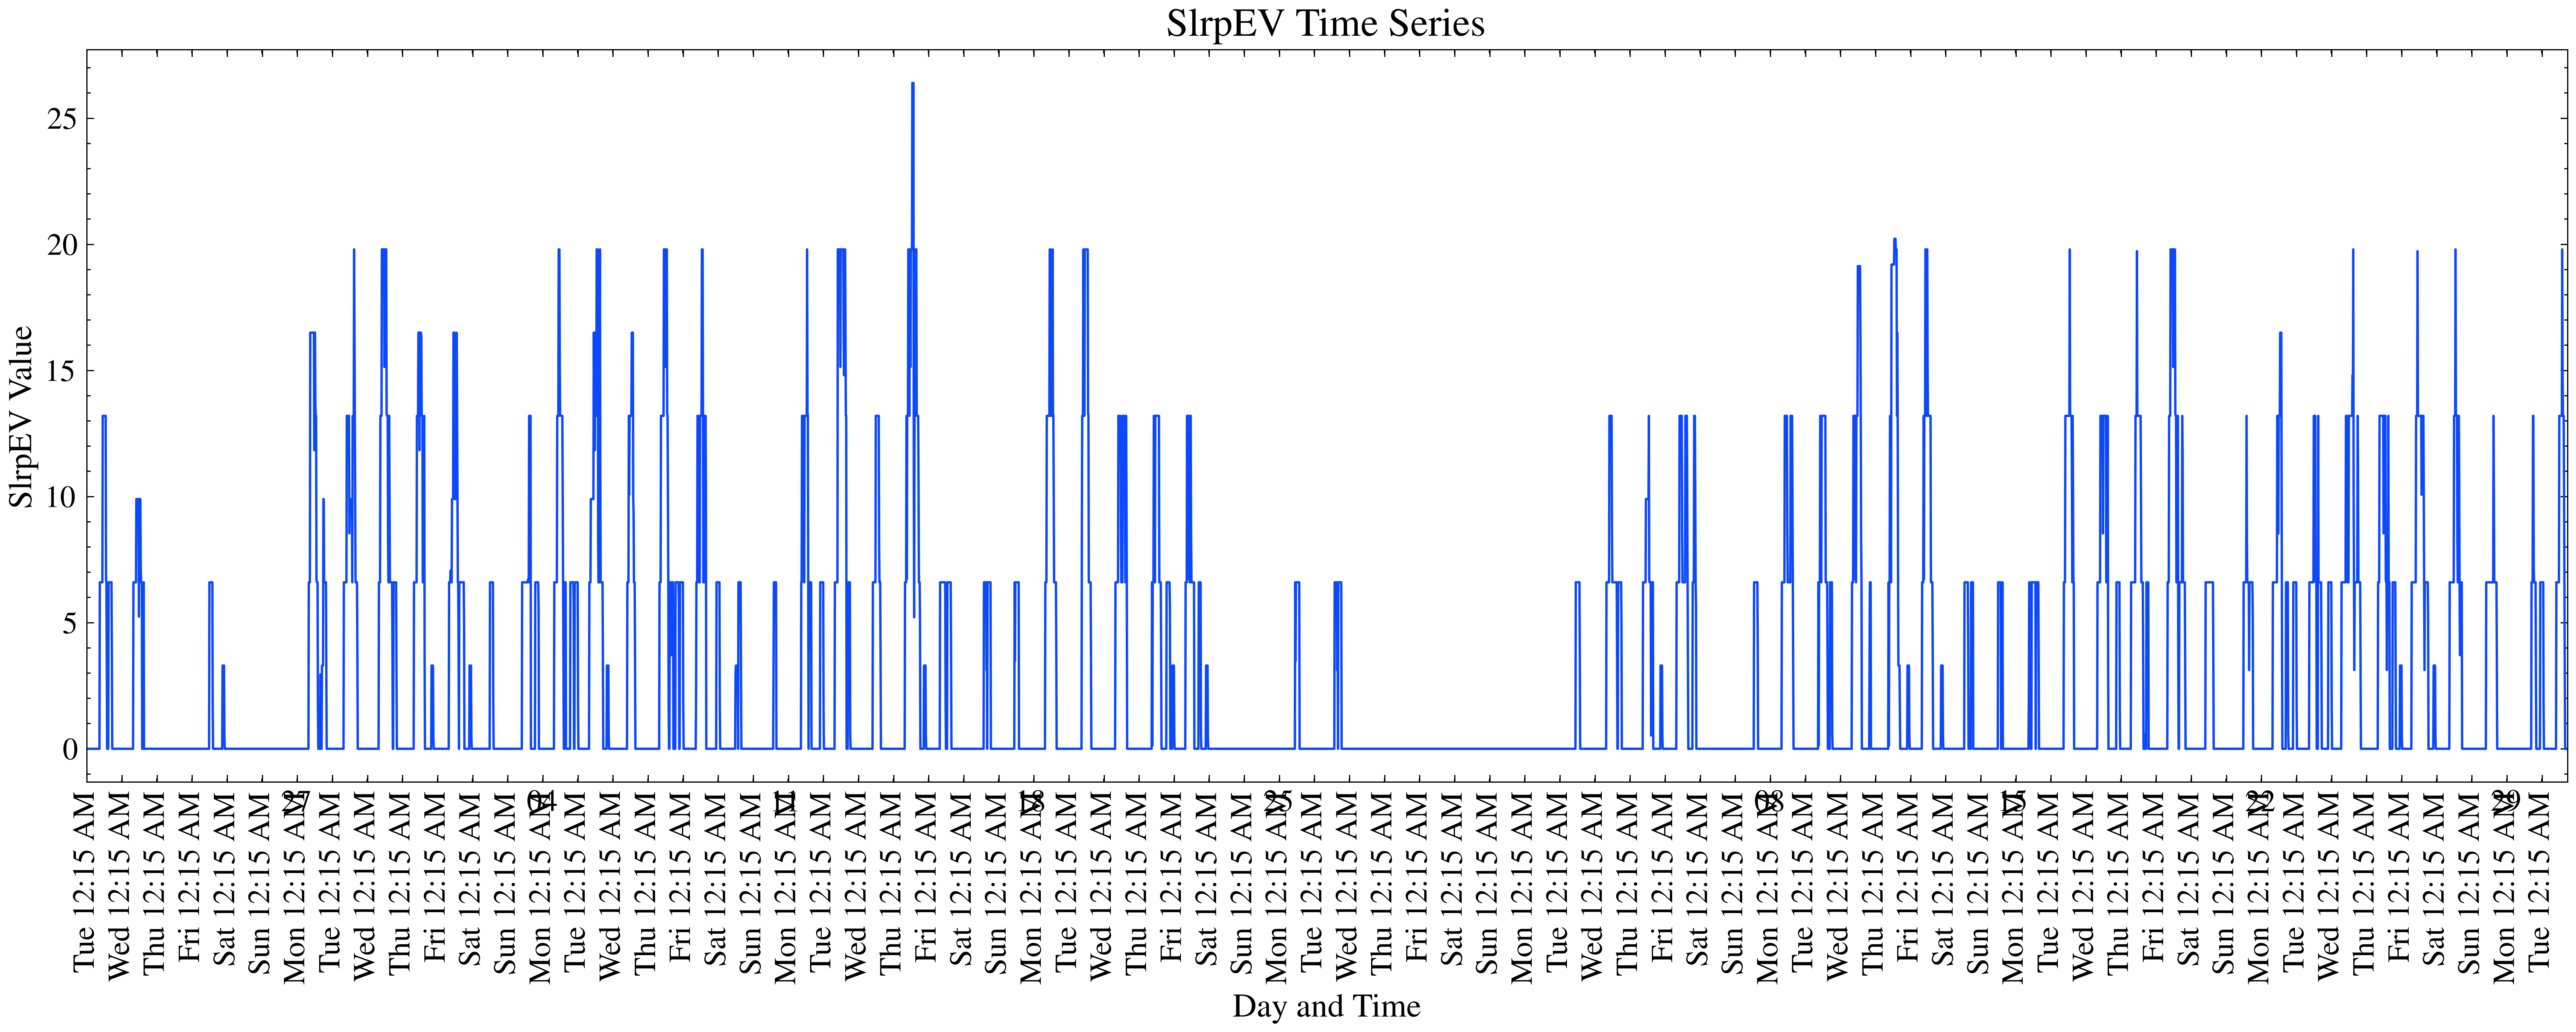

In [18]:

# Correcting the issue with multiple labels

# Setting the major ticks to be every 12 hours
# Using a DateLocator to ensure proper alignment of ticks with the datetime index
from matplotlib.dates import HourLocator, DateFormatter
df_sessions=df_sessions[df_sessions.index>pd.Timestamp(year=2023,month=11,day=21,hour=0)]
df_sessions = df_sessions.fillna(0)
peak_df = (df_sessions.fillna(0).sum(axis=1) / 1000)
plt.figure(figsize=(15, 6))
ax = peak_df.plot()
# ax = df_sessions.sum(axis=1).plot()

# Removing the default x-axis labels
ax.set_xticklabels([])
# # Setting the x-axis major ticks and labels
# ax.xaxis.set_major_locator(HourLocator(byhour=range(0, 24, 12)))  # Every 12 hours
# ax.xaxis.set_major_formatter(DateFormatter('%a %I:%M %p'))  # Formatting as day and time

# Set x-ticks at 12-hour intervals
tick_spacing = 48 * 2 # There are 4 data points per hour, so 48 points for 12 hours
tick_labels = peak_df.index[::tick_spacing].strftime('%a %I:%M %p')  # Labels for every 12 hours

ax.set_xticks(peak_df .index[::tick_spacing], tick_labels, rotation=90)

plt.xlabel('Day and Time')
plt.ylabel('SlrpEV Value')
plt.title('SlrpEV Time Series')
plt.tight_layout()
plt.show()

In [19]:
peak_df[peak_df.index>pd.Timestamp(year=2023,month=12,day=21,hour=0)]
peak_df[peak_df>=19]

timestamp
2023-11-28 15:00:00    19.80
2023-11-29 10:00:00    19.80
2023-11-29 10:15:00    19.80
2023-11-29 10:30:00    19.80
2023-11-29 10:45:00    19.80
                       ...  
2024-01-19 13:00:00    19.80
2024-01-24 15:00:00    19.80
2024-01-26 11:00:00    19.73
2024-01-27 13:00:00    19.80
2024-01-30 14:00:00    19.80
Length: 126, dtype: float64

In [77]:
# print(len(df.loc[392,'sessions']),df.loc[392,'sessions'])

# print(len(df.loc[402,'sessions']), df.loc[402,'sessions'])  # 6290, 6291,6292, 6293, 6294, 6295  (11:50)

# print(len(df.loc[403,'sessions']), df.loc[403,'sessions']) # 6291,6292, 6293, 6294, 6295,6295, 6296
# df.loc[403,'sessions'][5],df.loc[403,'sessions'][6],df.loc[403,'sessions'][7]
session_df[['userId','connectTime','choice','reg_centsPerHr','sch_centsPerHr']].tail(20)

userId         connectTime     choice reg_centsPerHr sch_centsPerHr
4601   1276 2024-01-18 16:01:32  SCHEDULED            208            143
4966   1371 2024-01-19 07:17:18    REGULAR            203            166
5123   1436 2024-01-19 07:25:26    REGULAR            150            200
4878    867 2024-01-19 07:44:44    REGULAR            150            200
1133    682 2024-01-19 07:45:40  SCHEDULED            150            200
5135    689 2024-01-19 08:27:38    REGULAR            203            153
3949   1178 2024-01-19 09:22:40    REGULAR            204            154
3272   1149 2024-01-19 09:31:34    REGULAR            204            154
3516    834 2024-01-19 09:46:31    REGULAR            150            200
5004   1388 2024-01-19 09:59:40    REGULAR            202            137
4050   1208 2024-01-19 11:35:14  SCHEDULED            211            145
2397   1060 2024-01-19 12:11:12    REGULAR            207            171
4292   1217 2024-01-19 15:31:57    REGULAR            206            141
4225   1027 2024-01-19 17:50:12    REGULAR            208            143
4478   1258 2024-01-19 18:39:44    REGULAR            208            143
4293   1217 2024-01-20 09:12:01    REGULAR            205            163
3483   1163 2024-01-20 10:37:36    REGULAR            NaN            NaN
4479   1258 2024-01-21 11:23:36    REGULAR            205            163
2398   1060 2024-01-21 13:48:12    REGULAR            208            175
2399   1060 2024-01-21 15:25:05    REGULAR            206            141

In [68]:
# Process the data using iterrows
# def generate_stateRecord_df():

df = pd.DataFrame(stateRecords, 
                  columns=['timestamp', 'sort_key','monthlyPeak', 'sessions'])
df = df.sort_values(by='timestamp').reset_index(drop=True)

df.rename(columns={'timestamp':'opt_timestamp'},inplace=True)
df['opt_timestamp'] = pd.to_datetime(df['opt_timestamp'],unit='s')

processed_data = []

for _, row in df.iterrows():
    sessions = row['sessions']
    if len(sessions) >0:
        ### Changing minds --> now we want to 
        threshold_ts = unixTime(row['opt_timestamp'] )
        # Counting sessions and identifying duplicates
        session_ids = [session['dcosId'] for session in sessions]
        num_sessions = len(session_ids)
        duplicates = {dcosId for dcosId in session_ids if session_ids.count(dcosId) > 1}
        if len(duplicates)>=1:
            duplicates = list(duplicates)
        else: 
            duplicates = None
        # Finding the overall time range for the power profiles
        all_timestamps = sorted({timestamp for session in sessions for timestamp, _ in session['optPower']})

        # Creating the power profile array
        power_profile = np.zeros((num_sessions, len(all_timestamps)))

        for i, session in enumerate(sessions):
            session_times = {timestamp for timestamp, _ in session['optPower']}
            for j, timestamp in enumerate(all_timestamps):
                if timestamp in session_times:
                    power = next(power for time, power in session['optPower'] if time == timestamp)
                    power_profile[i, j] = power

        observed_power_profile = power_profile[:, [t <= threshold_ts for t in all_timestamps]]
        planned_power_profile = power_profile[:, [t >= threshold_ts for t in all_timestamps]]


        # Appending to processed data
        processed_data.append({
            'num_sessions': num_sessions,
            'duplicated_session': duplicates,
            'power_profile': power_profile,
            'peak_value':  np.max(np.sum(power_profile, axis=0)),
            'observed_peak_value': np.max(np.sum(observed_power_profile, axis=0)),
            'observed_power_profile': observed_power_profile,
            'planned_power_profile': planned_power_profile,
            'session_ids':session_ids,
            'all_timestamps':all_timestamps
        })

    else:
            processed_data.append({
            'num_sessions': 0,
            'duplicated_session': None,
            'power_profile': [],
            'peak_value':  0,
            'observed_peak_value': 0,
            'observed_power_profile': [],
            'planned_power_profile': [],
            'session_ids':[],
            'all_timestamps':[]
            })
# processed_data now contains the results for each row of the DataFrame
# Add new columns to the DataFrame
df['num_sessions'] = 0
df['duplicated_session'] = None
df['power_profile'] = None
df['peak_value'] = 0
df['observed_peak_value'] = 0
df['observed_power_profile'] = None
df['planned_power_profile'] = None
df['all_timestamps'] = None
df['session_ids'] = None

for index, processed_row in enumerate(processed_data):
    df.at[index, 'num_sessions'] = processed_row['num_sessions']
    df.at[index, 'duplicated_session'] = processed_row['duplicated_session']
    df.at[index, 'power_profile'] = processed_row['power_profile']
    df.at[index, 'peak_value'] = processed_row['peak_value']
    df.at[index, 'observed_peak_value'] = processed_row['observed_peak_value']
    df.at[index, 'observed_power_profile'] = processed_row['observed_power_profile']
    df.at[index, 'planned_power_profile'] = processed_row['planned_power_profile']
    df.at[index, 'all_timestamps'] = processed_row['all_timestamps']
    df.at[index, 'session_ids'] = processed_row['session_ids']
df = df[df['opt_timestamp'] > pd.Timestamp(year=2023,month=10,day=26,hour=8)]
df = df.sort_values(by=['opt_timestamp','sort_key']).drop_duplicates(subset='opt_timestamp',keep='last')
df = df.drop_duplicates('session_ids',keep='first')
# return df

In [70]:
session_df['']

choice vehicle_maxChgRate_W siteId peakPower_W   estCost  \
4860    REGULAR                 6600     25           0  11.14878   
5041    REGULAR                11000     25        6813   9.54284   
1812  SCHEDULED                55000     25           0   12.4196   
3809    REGULAR                 6600     25        6493   12.1219   
5042    REGULAR                11000     25        6821   0.92844   
...         ...                  ...    ...         ...       ...   
4293    REGULAR                11500     25           0  16.64545   
3483    REGULAR                50000     25           0       NaN   
4479    REGULAR               150000     25        6755   6.68758   
2398    REGULAR                40000     25        6680   3.66968   
2399    REGULAR                40000     25         125   3.06813   

     sch_centsPerHr         connectTime  DurationHrs  \
4860            166 2023-10-16 07:48:56      5.43305   
5041            168 2023-10-16 08:04:26      4.59027   
1812            168 2023-10-16 09:23:50      6.92972   
3809            168 2023-10-16 11:39:23      5.89944   
5042            169 2023-10-16 12:51:40      0.21638   
...             ...                 ...          ...   
4293            163 2024-01-20 09:12:01      7.87583   
3483            NaN 2024-01-20 10:37:36      6.37249   
4479            163 2024-01-21 11:23:36      3.01833   
2398            175 2024-01-21 13:48:12      1.52388   
2399            141 2024-01-21 15:25:05      1.24666   

                  vehicle_model dcosId  ... sch_centsPerKwh  \
4860  Leaf  (30 kW-hr upgraded)   6099  ...               0   
5041                    Model Y   6102  ...               0   
1812               Clarity PHEV   6103  ...               0   
3809                       Leaf   6104  ...               0   
5042                    Model Y   6105  ...               0   
...                         ...    ...  ...             ...   
4293                    Model Y   6793  ...               0   
3483                       Bolt   6796  ...             NaN   
4479                    Mach -E   6799  ...               0   
2398                     e-Golf   6801  ...               0   
2399                     e-Golf   6802  ...               0   

     sch_centsPerOverstayHr            Deadline energyReq_Wh arrHour  \
4860                    300                 NaT          NaN       7   
5041                    300                 NaT          NaN       8   
1812                    300 2023-10-16 16:30:00        17000       9   
3809                    300                 NaT          NaN      11   
5042                    300                 NaT          NaN      12   
...                     ...                 ...          ...     ...   
4293                    300                 NaT          NaN       9   
3483                    NaN                 NaT          NaN      10   
4479                    300                 NaT          NaN      11   
2398                    300                 NaT          NaN      13   
2399                    300                 NaT          NaN      15   

     cumEnergy_KWh historical_peakPower_w             endTime highPower  \
4860        24.199                   6522 2023-10-16 13:15:05       1.0   
5041        29.620                   6859 2023-10-16 12:40:05       1.0   
1812        11.857                   6738 2023-10-16 16:20:05       1.0   
3809        36.372                   6611 2023-10-16 17:35:05       1.0   
5042         1.240                   6859 2023-10-16 13:05:05       1.0   
...            ...                    ...                 ...       ...   
4293        44.614                   6869 2024-01-20 17:05:05       1.0   
3483        28.609                   6888 2024-01-20 17:00:06       1.0   
4479        19.132                   6938 2024-01-21 14:25:05       1.0   
2398         6.208                   6749 2024-01-21 15:20:05       1.0   
2399         0.146                   6749 2024-01-21 16:40:0

In [22]:
# for session in row['session_ids']:
# Define colors for multiple sessions
observed_colors = ["#491F40", "#CE8936"]
planned_colors = ["#DBCCC6", "#E0C188"]

# Define other plot settings
opt_timestamp_color = "#DBA79C"
y_lim = 53  # 53 kW in watts


# Define other plot settings
opt_timestamp_color = "#DBA79C"
y_lim = 53  # 53 kW in watts


In [23]:
# Text above each subplot
def txt_function(row,ax):
    try:
        session_df.set_index('dcosId',inplace=True)
    except:
        print("")
    last_id = max(row['session_ids'])
    try:
        tariff = tuple(session_df.loc[last_id][["reg_centsPerHr", "sch_centsPerHr"]].values.astype(int))
    except:
        print("id: not in session_df",last_id)
        if last_id == 6253:
            tariff = (197,168)
        if last_id == 6259 or last_id == 6260:
            tariff = (208,180)
        else:
            tariff = (None,None)
    peak_power = row['monthlyPeak']
    if peak_power >= 19:
        peak_power = 16.8
    elem = [elem for elem in row['sessions'] if elem['dcosId'] == last_id][0]

    txt1 = "New Session: {}, Choice: {}, Tariff: {}-{} USD/hr".format(last_id, elem['choice'], tariff[0], tariff[1])


    # Adjust y_offset as needed to position text correctly
    y_offset = 1.05  # Position above the plot
    ax.text(0.5, y_offset, txt1, transform=ax.transAxes, ha='center', va='bottom')
    ax.axhline(peak_power , color='#E8113E', 
                   linestyle='--', label = 'Monthly Peak: {}kW'.format(peak_power),lw=1)
#     ax.text(0.5, y_offset + 0.05, txt2, transform=ax.transAxes, ha='center', va='bottom', fontsize=9)


In [24]:
import matplotlib.pyplot as plt
# Plotting
import matplotlib.dates as mdates

In [25]:
session_df[['connectTime','sch_centsPerHr','reg_centsPerHr']].tail(40)

connectTime sch_centsPerHr reg_centsPerHr
3669 2023-11-20 08:46:54            263            263
3390 2023-11-20 09:21:23            200            150
3028 2023-11-20 10:28:49            200            150
3684 2023-11-20 18:07:45            138            204
3700 2023-11-21 08:02:59            NaN            NaN
3348 2023-11-21 10:13:41            145            212
3096 2023-11-21 10:47:01            200            150
3613 2023-11-21 14:02:41            263            263
3703 2023-11-22 09:37:25            131            131
2686 2023-11-22 11:42:13            138            204
3605 2023-11-22 12:27:19              0              0
3202 2023-11-24 10:46:49            263            263
3349 2023-11-24 11:28:16            263            263
3350 2023-11-25 14:11:01            263            263
3626 2023-11-27 07:29:28            263            263
3670 2023-11-27 08:24:43            263            263
3701 2023-11-27 08:50:07            263            263
3488 2023-11-27 08:53:16            131            131
3351 2023-11-27 11:30:43            138            204
3685 2023-11-27 17:14:34            138            204
3589 2023-11-28 07:48:25            263            263
3671 2023-11-28 08:11:48            263            263
3137 2023-11-28 09:50:54            263            263
3282 2023-11-28 09:59:51            138            204
3646 2023-11-28 10:47:50            138            204
3460 2023-11-28 12:03:43            263            263
3694 2023-11-28 13:38:46            263            263
3632 2023-11-28 14:55:13            131            131
1117 2023-11-29 07:38:47            263            263
2003 2023-11-29 08:40:49            131            131
2105 2023-11-29 09:00:06            263            263
1598 2023-11-29 09:52:00            263            263
3660 2023-11-29 11:40:04            138            204
2723 2023-11-29 14:22:22            263            263
3695 2023-11-30 08:03:18            263            263
3193 2023-11-30 09:01:00            263            263
3283 2023-11-30 09:01:22            263            263
3704 2023-11-30 10:26:12            131            131
3489 2023-12-01 10:23:17            200            150
3029 2023-12-01 10:26:02            200            150

In [26]:
df = df[df['opt_timestamp'] >= pd.Timestamp(year=2023,month=11,day=30,hour=7,minute=0)]
output_directory = '/Users/aysetugbaozturk/Documents/eCal/SlrpEV/SlrpEV_algorithms/Figures'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
# unix_time_index = np.arange(start=row['all_timestamps'][0], stop= unixTime(pd.Timestamp(year=2023,month=10,day=23,hour=23)), step = 15 * 60)
# df_base = pd.DataFrame(index = unix_time_index)
rows=8
# # Create a figure and axes with shared x-axis
fig, axs= plt.subplots(nrows=rows, ncols=1, figsize=(10,rows*2.6))

# Loop through each row of the DataFrame and create a plot
for index, (ax, (_,row)) in enumerate(zip(axs, df.iterrows())):
# row = df.loc[235]
    txt_function(row,ax)
    session_ids = row['session_ids'].copy()
    try:
        df_state = pd.DataFrame(index=row['all_timestamps'],data = row['power_profile'].T/1000, columns=row['session_ids'])   
    except:
        print(row)
    opt_time = unixTime(row['opt_timestamp'].round('15min'))
    df_state.reset_index(drop=False,inplace=True)
    df_state['observed'] = df_state['index']<=opt_time
    df_state['index'] = pd.to_datetime(df_state['index'],unit='s')
#     if 6252 in row['session_ids']:
#         missing_6252 = df_state.loc[:,['index',6252]]
#     if index ==4:
#         session_ids.insert(0,6252)
#         df_state.set_index('index',inplace=True)
#         df_state[6252] = missing_6252.set_index('index')[6252]
#         df_state.reset_index(drop=False,inplace=True)
#         observed_index = range(0,df_state['observed'].idxmin() - 1)
#         planned_index = range(df_state['observed'].idxmin() - 1,len(df_state))
#     else:

    observed_index = range(0,df_state['observed'].idxmin())
    planned_index = range(df_state['observed'].idxmin() - 1,len(df_state))
    if df_state['observed'].idxmin() == 0:
        planned_index  = []
        
    ax.axvline(row['opt_timestamp'].round('15min'), color=opt_timestamp_color, 
                   linestyle='--', label = 'Current Time:\n{}'.format(row['opt_timestamp']),lw=2)


    for i, session in enumerate(session_ids):
        
        ts = df_state.loc[observed_index,'index']
        f_low = df_state.loc[observed_index,session_ids[:i]].sum(axis=1)
        f_high = f_low + df_state.loc[observed_index,session_ids[i]]
        ax.fill_between(ts,  f_low, f_high,color=observed_colors[0],edgecolor='white',step='post')
        
        ts = df_state.loc[planned_index,'index']
        f_low = df_state.loc[planned_index,session_ids[:i]].sum(axis=1)
        f_high = f_low + df_state.loc[planned_index,session_ids[i]]
        ax.fill_between(ts,  f_low, f_high,color=planned_colors[0], edgecolor='white', step='post')


    # Setting labels and titles
    ax.set_ylabel('Power (W)')
#     ax.set_title(f'Power Profiles for Row {index}')
    ax.set_ylim(0, y_lim)
    ax.set_xlim(pd.Timestamp(year=2023,month=11,day=30,hour=7), pd.Timestamp(year=2023,month=12,day=1,hour=22))
    ax.legend(loc='upper right')
#         ax.grid(alpha=0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # Save the plot
    plt.xticks(rotation=0)
    plt.xlabel('Timestamp')


#     plt.close(fig)  # Close the figure to free memory


    # Break the loop after 3 plots
    if index >= rows:
        break
# Format x-axis to show datetime properly
#     axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# output_path = os.path.join(output_directory, '2023112728_peak19.png')
# plt.savefig(output_path)

# Set common xlabel




id: not in session_df 6476



id: not in session_df 6485

id: not in session_df 6485

id: not in session_df 6488

id: not in session_df 6489

id: not in session_df 6490


In [314]:
session_df

choice vehicle_maxChgRate_W siteId peakPower_W   estCost  \
dcosId                                                                
6102      REGULAR                11000     25        6813   9.54284   
6104      REGULAR                 6600     25        6493   12.1219   
6105      REGULAR                11000     25        6821   0.92844   
6107    SCHEDULED                 6600     25         807   7.15325   
6108      REGULAR                 7400     25        7789   4.54821   
...           ...                  ...    ...         ...       ...   
6484      REGULAR                 1000     25        6369   1.74886   
6489      REGULAR                52000     25        6714  10.16305   
6491      REGULAR                 6600     25        6349   1.73285   
6492      REGULAR                 3600     25        3404    1.5375   
6493      REGULAR                13000     25        6653   1.42083   

       sch_centsPerHr         connectTime  DurationHrs  \
dcosId                                                   
6102              168 2023-10-16 08:04:26      4.59027   
6104              168 2023-10-16 11:39:23      5.89944   
6105              169 2023-10-16 12:51:40      0.21638   
6107              181 2023-10-16 13:45:04      2.26055   
6108              177 2023-10-16 17:38:36      1.93694   
...               ...                 ...          ...   
6484              131 2023-11-30 10:26:12      0.95333   
6489              263 2023-12-01 07:23:59      3.67416   
6491              131 2023-12-01 10:08:22      0.94111   
6492              200 2023-12-01 10:23:17      0.69166   
6493              200 2023-12-01 10:26:02      0.61388   

                    vehicle_model          lastUpdate  ... sch_centsPerKwh  \
dcosId                                                 ...                   
6102                      Model Y 2023-10-16 12:40:05  ...               0   
6104                         Leaf 2023-10-16 17:35:05  ...               0   
6105                      Model Y 2023-10-16 13:05:05  ...               0   
6107    Leaf  (24 kW-hr upgraded) 2023-10-16 16:05:05  ...               0   
6108                 Wrangler 4ex 2023-10-16 19:35:05  ...               0   
...                           ...                 ...  ...             ...   
6484                      Model 3 2023-11-30 11:25:06  ...               0   
6489                         Bz4x 2023-12-01 11:05:05  ...               0   
6491                   Rav4 Prime 2023-12-01 11:05:05  ...               0   
6492                         Volt 2023-12-01 11:05:05  ...               0   
6493                       Mach-E 2023-12-01 11:05:05  ...               0   

       sch_centsPerOverstayHr            Deadline energyReq_Wh arrHour  \
dcosId                                                                   
6102                      300                 NaT          NaN       8   
6104                      300                 NaT          NaN      11   
6105                      300                 NaT          NaN      12   
6107                      300 2023-10-16 17:30:00        18000      13   
6108                      300                 NaT          NaN      17   
...                       ...                 ...          ...     ...   
6484                      300                 NaT          NaN      10   
6489                      300                 NaT          NaN       7   
6491                      300                 NaT          NaN      10   
6492                      300                 NaT          NaN      10   
6493                      300                 NaT          NaN      10   

       cumEnergy_KWh  historical_peakPower_w             endTime highPower  \
dcosId                                                                       
6102          29.620                    6821 2023-10-16 12:40:05       1.0   
6104          36.372                    6611 2023-10-16 17:35:05       1.0   
6105           1.240                    68

In [27]:

table = dynamodb.Table('optimizedPrices_v3_History')
# Scan the table
response = table.scan()
len(response['Items'])

45

In [225]:
# response['Items'][0]['timestamp']
# response['Items'][0]['optimizedPrices_v3_table']['sch_centsPerHr'],response['Items'][0]['optimizedPrices_v3_table']['reg_centsPerHr'],response['Items'][0]['optimizedPrices_v3_table']['highPower'],response['Items'][0]['optimizedPrices_v3_table']['arrHour']

In [237]:
# list(range(len(response['Items'][i]['optimizedPrices_v3_table']['arrHour']))

In [28]:
df_prices_list = []
for i in range(len(response['Items'])):
    record_ts = int(decimal_default(response['Items'][i]['timestamp']))
    df_prices = pd.DataFrame(columns = ['record_ts'],index=range(len(response['Items'][i]['optimizedPrices_v3_table']['arrHour'])))
    df_prices.loc[:,'record_ts'] = record_ts
    response['Items'][i]['optimizedPrices_v3_table']['arrHour'].values()
    sch = response['Items'][i]['optimizedPrices_v3_table']['sch_centsPerHr'].values()
    reg = response['Items'][i]['optimizedPrices_v3_table']['reg_centsPerHr'].values()
    high_power = response['Items'][i]['optimizedPrices_v3_table']['highPower'].values()
    arrHour = response['Items'][i]['optimizedPrices_v3_table']['arrHour'].values()
    df_prices.loc[:,'SCH'] = sch
    df_prices.loc[:,'REG'] = reg
    df_prices.loc[:,'high_power'] = high_power
    df_prices.loc[:,'arrHour'] = arrHour
    df_prices_list.append(df_prices)
df_prices_all = pd.concat(df_prices_list)
df_prices_all = df_prices_all.sort_values(by=['record_ts','arrHour'])
df_prices_all['record_ts'] = pd.to_datetime(df_prices_all['record_ts'],unit='s')

In [29]:
df_prices_all

record_ts                 SCH                 REG high_power  \
4  2023-10-03 16:24:41  177.14334841034363  209.42445431217962          1   
7  2023-10-03 16:24:41   96.03608455366592  111.61411573884473          0   
1  2023-10-03 16:24:41   96.03607471384721  111.61410572613518          0   
5  2023-10-03 16:24:41  177.14335546655442   209.4244622983787          1   
2  2023-10-03 16:24:41   96.03606374637378  111.61409586190469          0   
..                 ...                 ...                 ...        ...   
9  2023-12-09 03:15:00  107.58158212440912   114.9635432374754          0   
0  2023-12-09 03:15:00  107.58160378971226  114.96355957630311          0   
6  2023-12-09 03:15:00    180.237750389024  213.00743081034523          1   
1  2023-12-09 03:15:00  103.74396057227575  112.51777908635502          0   
8  2023-12-09 03:15:00  166.19657524637074   203.6222382247573          1   

   arrHour  
4       16  
7       16  
1       17  
5       17  
2       18  
..     ...  
9        5  
0        6  
6        6  
1        7  
8        7  

[430 rows x 5 columns]

In [30]:
df_sub = df_prices_all[(df_prices_all['record_ts']  <= pd.Timestamp(year=2023, month=11, day=19,hour=0))]
df_sub = df_sub [df_sub['arrHour'].isin([9,10,11,12,13])]
idx = df_sub[df_sub['record_ts'] >= pd.Timestamp(year=2023, month=11, day=13,hour=9)].index
df_sub.loc[:,'z0_gap'] = "SCH, REG: [165, 198] or [82, 99]"
df_sub.loc[idx,'z0_gap'] = "SCH, REG: [132, 198] or [66, 99]"
df_sub['diff'] =df_sub['REG'] - df_sub['SCH']
df_sub

record_ts                 SCH                 REG high_power  \
2  2023-10-12 04:15:00  168.69972245125084  197.92518397415677          1   
5  2023-10-12 04:15:00   92.49908457729416  100.90852821439121          0   
1  2023-10-12 08:39:39  168.69972245125084  197.92518397415677          1   
5  2023-10-12 08:39:39   87.89928662355145    99.3448151635972          0   
2  2023-10-12 08:39:39  165.52270937745715  197.32096568220342          1   
..                 ...                 ...                 ...        ...   
9  2023-11-08 09:37:54   92.49908935043035  100.90853116876328          0   
6  2023-11-08 09:37:54  181.46394516096285  198.34035497212554          1   
10 2023-11-08 09:37:54   92.37142554882993  101.35294147296281          0   
1  2023-11-13 13:30:00   145.9807225731208  212.77239108816562          1   
4  2023-11-13 13:30:00   75.92287395550093  110.57271747212103          0   

   arrHour                            z0_gap               diff  
2        9  SCH, REG: [165, 198] or [82, 99]  29.22546152290593  
5        9  SCH, REG: [165, 198] or [82, 99]   8.40944363709705  
1        9  SCH, REG: [132, 198] or [66, 99]  29.22546152290593  
5        9  SCH, REG: [165, 198] or [82, 99]  11.44552854004575  
2       10  SCH, REG: [165, 198] or [82, 99]  31.79825630474627  
..     ...                               ...                ...  
9       12  SCH, REG: [165, 198] or [82, 99]   8.40944181833293  
6       13  SCH, REG: [165, 198] or [82, 99]  16.87640981116269  
10      13  SCH, REG: [165, 198] or [82, 99]   8.98151592413288  
1       13  SCH, REG: [132, 198] or [66, 99]  66.79166851504482  
4       13  SCH, REG: [132, 198] or [66, 99]  34.64984351662010  

[106 rows x 7 columns]

In [31]:
df_test =  df_sub.groupby(['high_power','arrHour', 'z0_gap']).mean()
df_test['diff'] = df_test['REG'] - df_test['SCH']
df_test

record_ts  \
high_power arrHour z0_gap                                                           
0          9       SCH, REG: [165, 198] or [82, 99] 2023-10-21 02:29:24.555555584   
           10      SCH, REG: [165, 198] or [82, 99] 2023-10-23 12:16:23.000000000   
           11      SCH, REG: [165, 198] or [82, 99] 2023-10-26 17:58:49.583333376   
           12      SCH, REG: [132, 198] or [66, 99] 2023-11-05 12:28:12.000000000   
                   SCH, REG: [165, 198] or [82, 99] 2023-10-26 17:58:49.583333376   
           13      SCH, REG: [132, 198] or [66, 99] 2023-11-13 13:30:00.000000000   
                   SCH, REG: [165, 198] or [82, 99] 2023-10-28 23:34:49.909090816   
1          9       SCH, REG: [132, 198] or [66, 99] 2023-10-21 00:00:25.666666496   
                   SCH, REG: [165, 198] or [82, 99] 2023-10-21 03:43:54.000000000   
           10      SCH, REG: [132, 198] or [66, 99] 2023-10-25 09:28:21.000000000   
                   SCH, REG: [165, 198] or [82, 99] 2023-10-21 00:00:25.666666496   
           11      SCH, REG: [132, 198] or [66, 99] 2023-10-19 20:20:09.500000000   
                   SCH, REG: [165, 198] or [82, 99] 2023-10-28 03:06:33.600000000   
           12      SCH, REG: [132, 198] or [66, 99] 2023-10-29 10:49:17.000000000   
                   SCH, REG: [165, 198] or [82, 99] 2023-10-21 00:00:25.666666496   
           13      SCH, REG: [132, 198] or [66, 99] 2023-11-13 13:30:00.000000000   
                   SCH, REG: [165, 198] or [82, 99] 2023-10-28 23:34:49.909090816   

                                                            SCH         REG  \
high_power arrHour z0_gap                                                     
0          9       SCH, REG: [165, 198] or [82, 99]   98.981647  106.910076   
           10      SCH, REG: [165, 198] or [82, 99]   92.117423  104.183617   
           11      SCH, REG: [165, 198] or [82, 99]  102.529252  110.073577   
           12      SCH, REG: [132, 198] or [66, 99]   92.499089  100.908531   
                   SCH, REG: [165, 198] or [82, 99]   96.773256  105.795349   
           13      SCH, REG: [132, 198] or [66, 99]   75.922874  110.572717   
                   SCH, REG: [165, 198] or [82, 99]   90.786332  100.577199   
1          9       SCH, REG: [132, 198] or [66, 99]  168.699722  197.925184   
                   SCH, REG: [165, 198] or [82, 99]  174.129408  204.467236   
           10      SCH, REG: [132, 198] or [66, 99]  165.990394  197.151977   
                   SCH, REG: [165, 198] or [82, 99]  165.522709  197.320966   
           11      SCH, REG: [132, 198] or [66, 99]  168.699723  197.925184   
                   SCH, REG: [165, 198] or [82, 99]  188.452386  216.189992   
           12      SCH, REG: [132, 198] or [66, 99]  169.182608  198.635321   
                   SCH, REG: [165, 198] or [82, 99]  169.786017  198.432503   
           13      SCH, REG: [132, 198] or [66, 99]  145.980723  212.772391   
                   SCH, REG: [165, 198] or [82, 99]  181.133424  198.631361   

                                                          diff  
high_power arrHour z0_gap                                       
0          9       SCH, REG: [165, 198] or [82, 99]   7.928429  
           10      SCH, REG: [165, 198] or [82, 99]  12.066194  
           11      SCH, REG: [165, 198] or [82, 99]   7.544326  
           12      SCH, REG: [132, 198] or [66, 99]   8.409442  
                   SCH, REG: [165, 198] or [82, 99]   9.022093  
           13      SCH, REG: [132, 198] or [66, 99]  34.649844  
                   SCH, REG: [165, 198] or [82, 99]   9.790867  
1          9       SCH, REG: [132, 198] or [66, 99]  29.225462  
                   SCH, REG: [165, 198] or [82, 99]  30.337828  
           10      SCH, REG: [132, 198] or [66, 99]  31.161583  
                   SCH, REG: [165, 198] or [82, 99]  31.798256  
           11      SCH, REG: [132, 198] or [66, 99]  29.225461  
                   SCH, REG: [165, 198] or [

In [32]:
plt.style.use(['science','ieee','high-vis'])
plt.rcParams['font.size'] = 14
w = 7/1.1
h = 3/1.1

high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
matplotlib.rc('axes', labelsize=14)

In [33]:
filtered_df

NameError: name 'filtered_df' is not defined

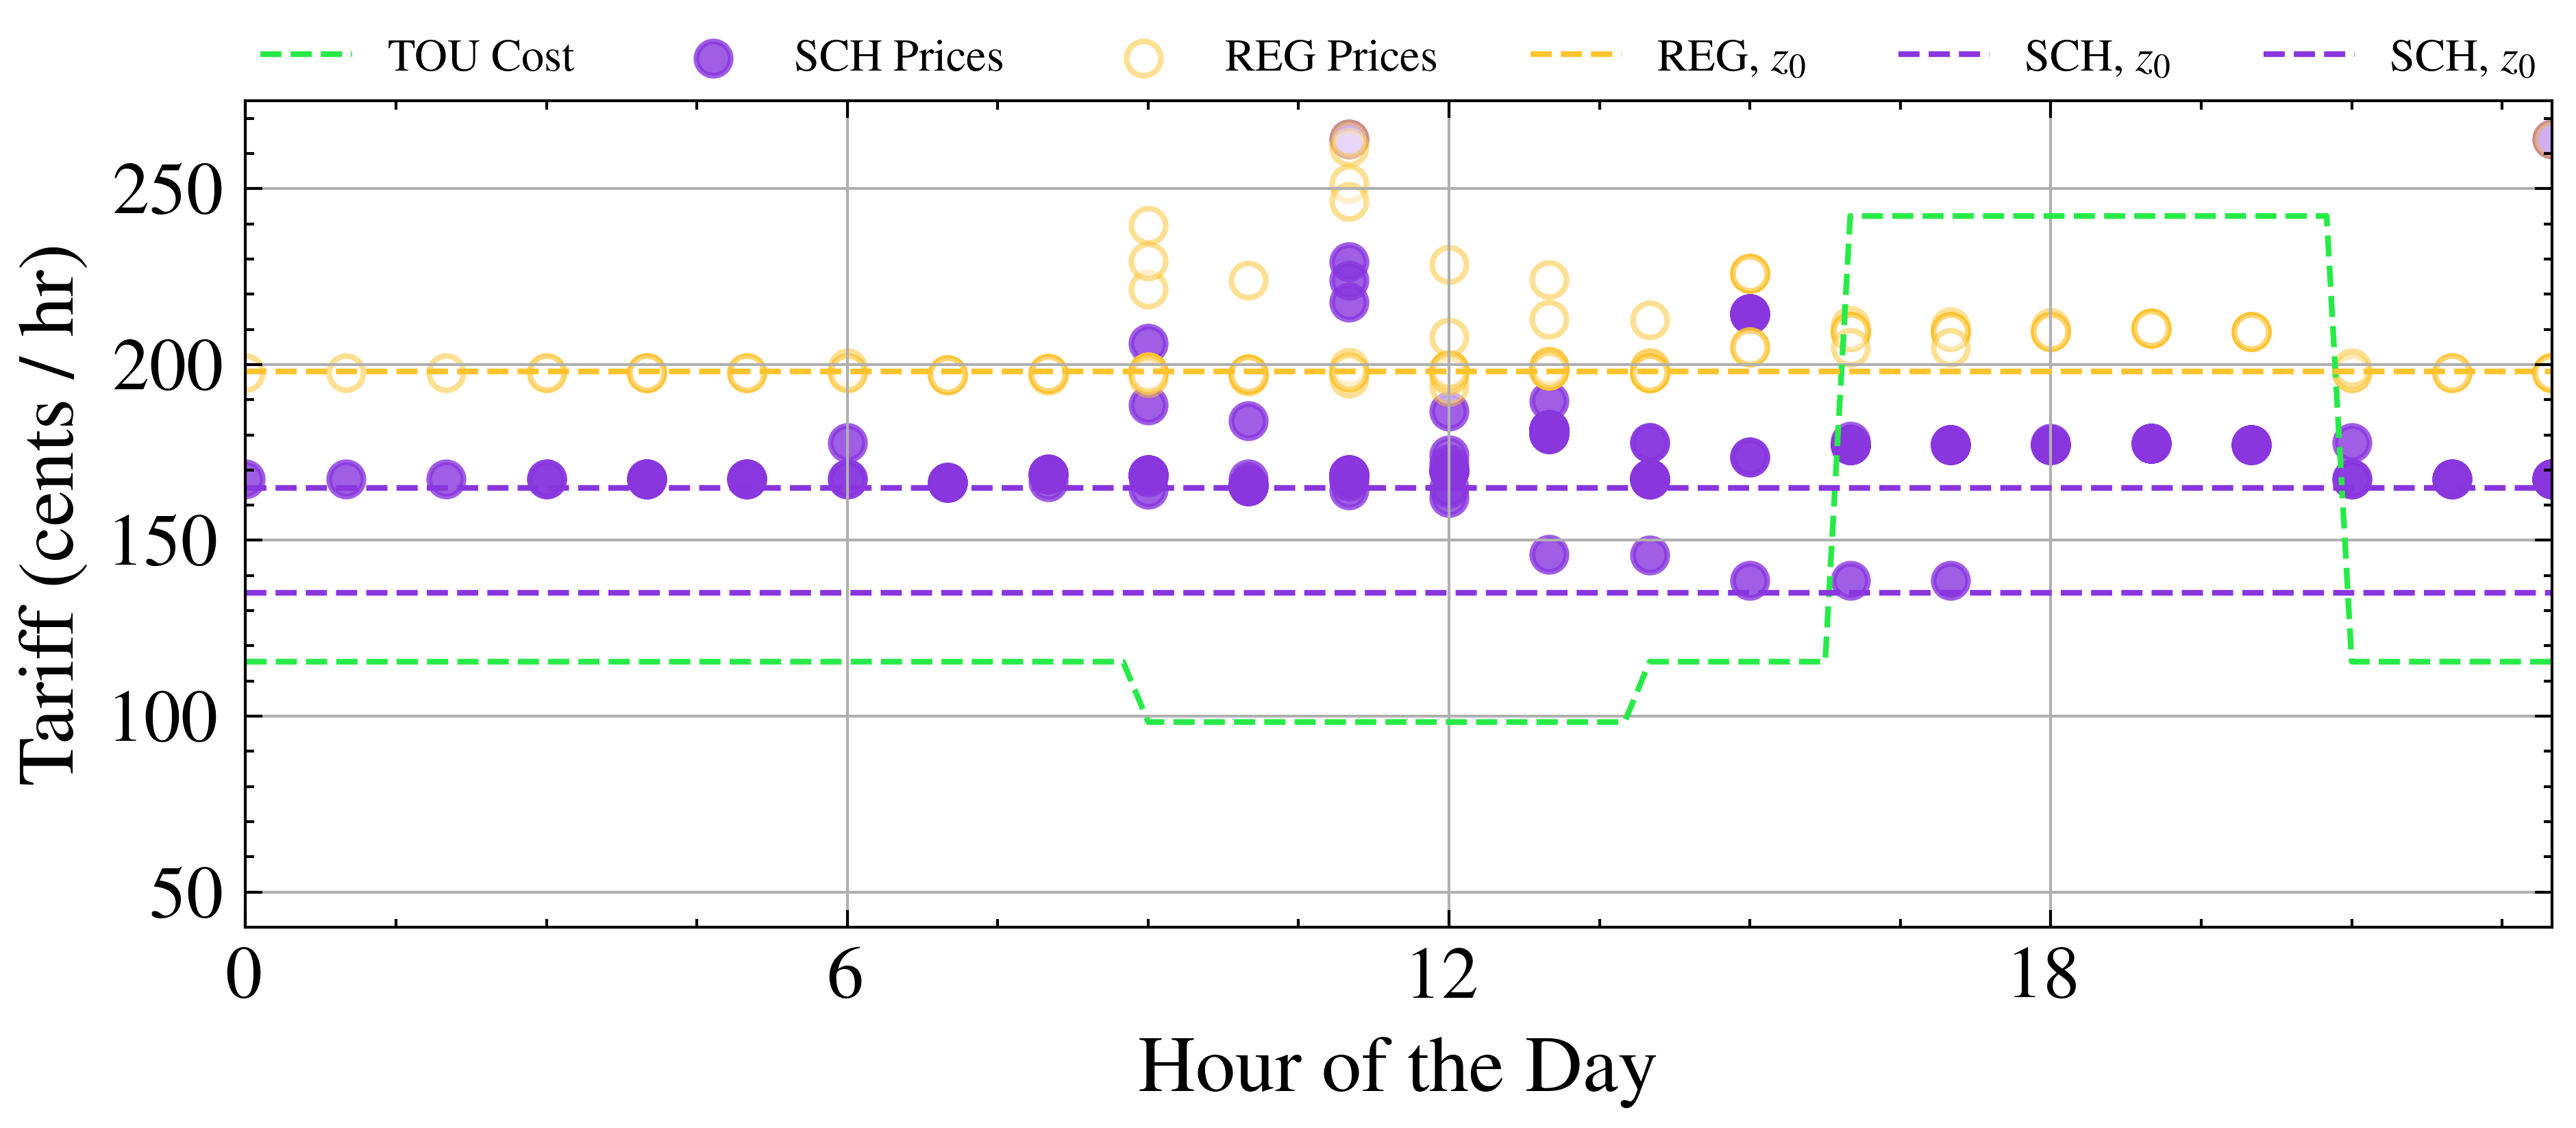

In [262]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data and existing plot setup
# fig,ax= plt.subplots(1,1,figsize=(w,h)

# Prepare the DataFrame
# Assuming df is your DataFrame with SCH, REG, arrHour, and high_power columns
df_prices_all = df_prices_all[(df_prices_all['record_ts']  <= pd.Timestamp(year=2023, month=11, day=17,hour=0))]
filtered_df = df_prices_all[df_prices_all['high_power'] == 1]

# Grouping the data for box/violin plots
sch_prices = filtered_df.groupby('arrHour')['SCH'].apply(list)
reg_prices = filtered_df.groupby('arrHour')['REG'].apply(list)
hours = filtered_df['arrHour'].unique()

# Plot initial guess vs optimization result
fig, ax = plt.subplots(1, 1, figsize=(w, h))

# Existing plot
ax.plot(np.arange(0, 24, 0.25), tou[0], label='TOU Cost', ms=0, marker='X',
        linestyle="--", color=high_vis_map[2])

# Add scatter plots for SCH and REG prices
ax.scatter(filtered_df['arrHour'], filtered_df['SCH'],  label='SCH Prices', alpha=0.8,color=high_vis_map[3])
ax.scatter(filtered_df['arrHour'], filtered_df['REG'], facecolor="white",label='REG Prices', alpha=0.5,edgecolor=high_vis_map[4])
ax.axhline(198 , color=high_vis_map[4], 
                   linestyle='--', label = 'REG, $z_0$',lw=1)
ax.axhline(165 , color=high_vis_map[3], 
                   linestyle='--', label = 'SCH, $z_0$',lw=1)
ax.axhline(135 , color=high_vis_map[3], 
                   linestyle='--', label = 'SCH, $z_0$',lw=1)
# Set specific x-ticks
ax.set_xticks([0, 6, 12, 18])

# Set plot properties
ax.set_ylim(40, 275)
ax.set_xlim(0, 23)
ax.grid()
# ax.set_title("High Power Charging")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Tariff (cents / hr)")
ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=6, fontsize=8)

plt.show()


In [261]:
df
df = df_high.copy()
plt.figure(figsize=(5, 3))
plt.scatter(df.index, df['SCH'], label='SCH', marker='o', color='blue',s=2)
plt.scatter(df.index, df['REG'], label='REG', marker='o', color='red',s=2)
plt.plot(tou['index'],tou[0])
# Setting labels, title and legend
plt.xlabel('Index')
plt.ylabel('Tariff (cents/hr)')
plt.title('High Power, TOU Tariff Range :98 - 240 cents/hr')
plt.legend(frameon=True)
plt.grid(True)

# # Format the x-axis
# ax = plt.gca()  # Get current axis
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Major ticks every 3 hours
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %H:%M'))  # Day and hour
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# Display the plot
plt.tight_layout()
plt.show()

NameError: name 'df_high' is not defined

In [100]:

# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh

TOU_tariff[36:56] = 14.9

In [101]:
high_TOU = TOU_tariff * 6.6
low_TOU = TOU_tariff * 3.3
low_TOU.max(),low_TOU.min()

(121.11, 49.17)

In [102]:
high_TOU = TOU_tariff * 6.6
tou = pd.DataFrame(high_TOU).reset_index(drop=False)
tou['index'] = tou['index'] / 4

In [103]:
tou

index      0
0    0.00  115.5
1    0.25  115.5
2    0.50  115.5
3    0.75  115.5
4    1.00  115.5
..    ...    ...
91  22.75  115.5
92  23.00  115.5
93  23.25  115.5
94  23.50  115.5
95  23.75  115.5

[96 rows x 2 columns]